In [2]:
import matplotlib.pyplot as plt
from os import rename, listdir
import os.path
import os
from itertools import cycle
import numpy as np
import glob
import pandas as pd

## 0. Description<br>
**For each stella model, we have**<br>
0. The original STELLA model and **corrected with T_bb and T_eff** plots.
1. Corresponding JJ's SNEC input model, which has been classified as the most similar model(s).<br>
2. Files that had been generated by MESAtoSNEC(STELLA model) files. <br>

**NI_bound mass // Kinetic energy(Etot-Ebin) // M_exc in SNEC are calculated with the STELLA_mass*(STELLA_mass/SNEC_mass)**<br>
**M_ni remains the same in both codes**<br><br>
**STELLA_SNEC :** <br>
STELLA_name // <br>
SNEC_name // 

JJ-z014-10-0.3-0.6magnitudes.dat
Sm11p1000_JJ.tt.dat
Sm11p1000_JJ_SNECmagnitudes.dat
[False False False ...  True  True  True]
[False False False ...  True  True  True]
JJ-z014-10-0.6-2.8magnitudes.dat
Sm11p1200_JJ.tt.dat
Sm11p1200_JJ_SNECmagnitudes.dat
[False False False ...  True  True  True]
[False False False ...  True  True  True]
JJ-z014-12-0.4-2.8magnitudes.dat
Sm11p600_JJ.tt.dat
Sm11p600_JJ_SNECmagnitudes.dat
[False False False ...  True  True  True]
[False False False ...  True  True  True]
JJ-z014-10-0.3-0.6magnitudes.dat
Sm13p1200_JJ.tt.dat
Sm13p1200_JJ_SNECmagnitudes.dat
[False False False ...  True  True  True]
[False False False ...  True  True  True]


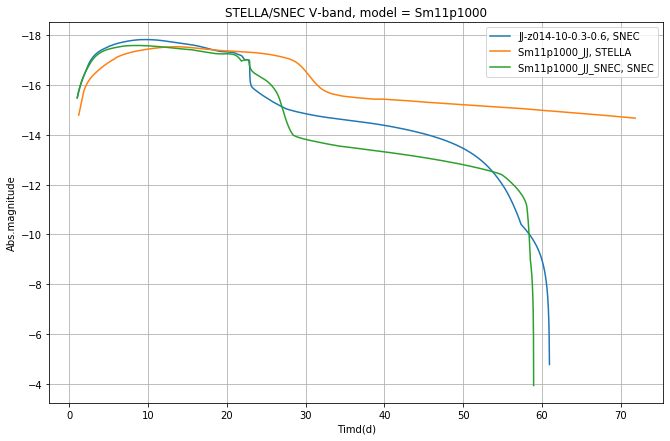

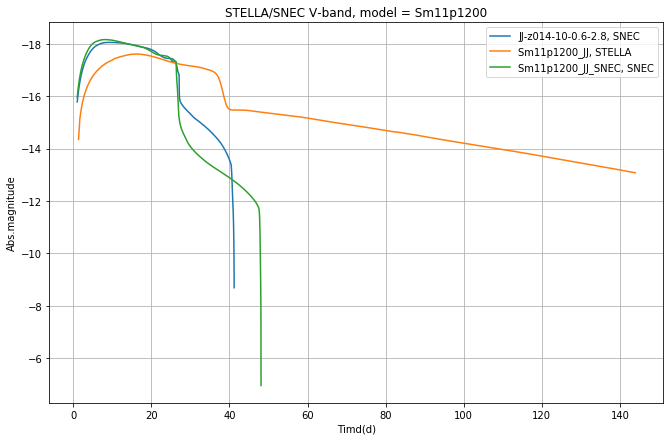

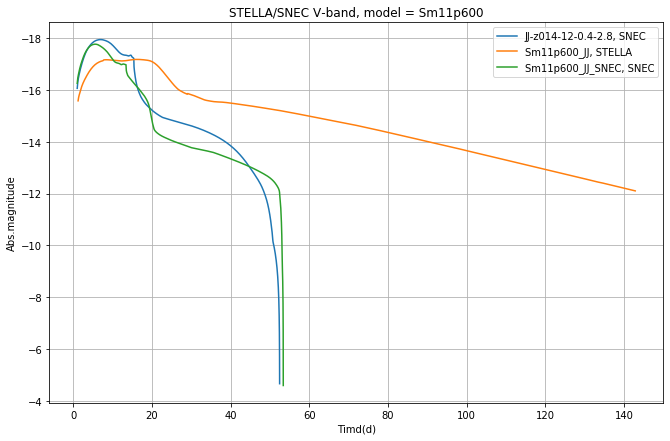

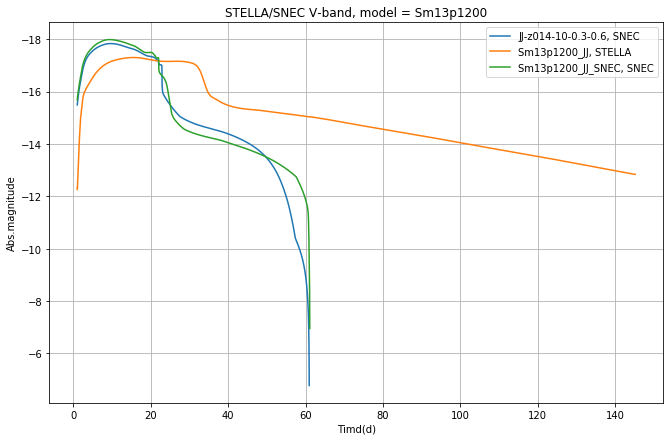

In [22]:
TOPPATH = 'D:/20-intern/comparison/'            # data file storage path
CORRPATH = 'D:/20-intern/BolCorr.dat'        # Corr file path
# TEST.
'''
f = open(TOPPATH+"Tm11p400_E1.0_m3.587_H0.155_Ni0.1_R2.633magnitudes.dat",'r')
print(f.read())
'''
# changing extensions
itr = 0
for i in listdir(TOPPATH):
    itr+=1                                                  # indicator for plots
    filedir = TOPPATH+i+'/'
    for file in listdir(TOPPATH+i):
        print(file)
        if file[-3:]!='dat':
            os.rename(filedir+file, filedir+file+'.dat')
# comparing
    plt.rcParams["figure.figsize"] = (11,7)
    plt.figure(itr)
    for file in listdir(TOPPATH+i):
        if file[-14:-4] == 'magnitudes':
            LC = np.genfromtxt(filedir + file)
            time = LC[:,0] ; V = LC[:,10] ; label = 'SNEC'
            mask = np.zeros(time.shape, bool)                   #masking SNEC file
            mask[time/86400>1] = True
            print(mask)
            plt.plot(time[mask]/86400, V[mask], label = file[:-14]+', '+label)
        else:
            LC = np.genfromtxt(filedir + file ,skip_header=86)
            time = LC[:,0] ; V = LC[:,9] ; label = 'STELLA'
            mask = np.zeros(time.shape, bool)                     #masking STELLA file
            mask[time > 1] = True
            plt.plot(time[mask], V[mask], label = file[:-7]+', '+label)
    plt.gca().invert_yaxis()
    plt.title("STELLA/SNEC V-band, model = %s"%i)
    plt.xlabel("Timd(d)");plt.ylabel("Abs.magnitude")
    plt.grid()
    plt.legend()

## 1. Bolometric correction

Text(0, 0.5, 'magnitude correction value')

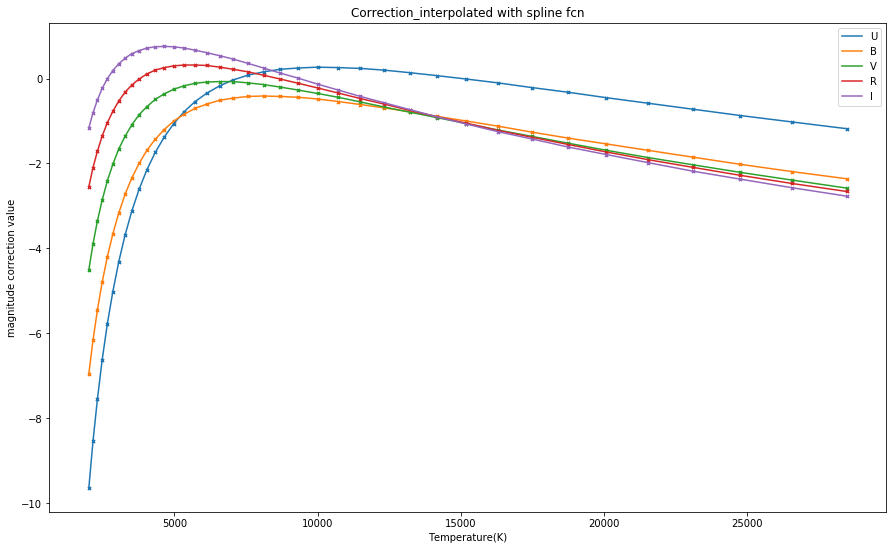

In [4]:
# get a cubic spline-interpolated f(f,T)
from scipy.interpolate import interp1d

BolCorr = np.genfromtxt(CORRPATH)
Type = ['U','B','V','R','I']
T = BolCorr[:,0] ; Value = BolCorr[:,-5:]

Bolintp = interp1d(T,Value, kind = 'cubic', axis = 0)
plt.rcParams["figure.figsize"] = (15,9)

mask = np.zeros(T.shape, bool)                         #masking with Temperature value
mask[(T>2000)&(T<30000)] = True

for i in np.arange(len(Type)):
    plt.plot(T[mask], Bolintp(T)[:,i][mask], label = Type[i])
    plt.scatter(T[mask], Value[:,i][mask], marker = "x", s = 10)
#plt.plot(T,Bolintp(T), label = Type)
plt.legend()
plt.title("Correction_interpolated with spline fcn")
plt.xlabel("Temperature(K)");plt.ylabel("magnitude correction value")

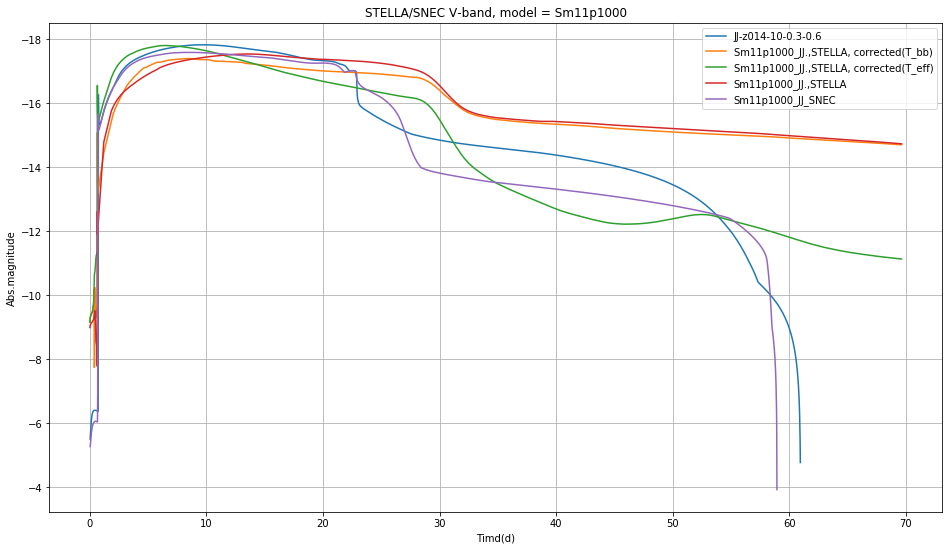

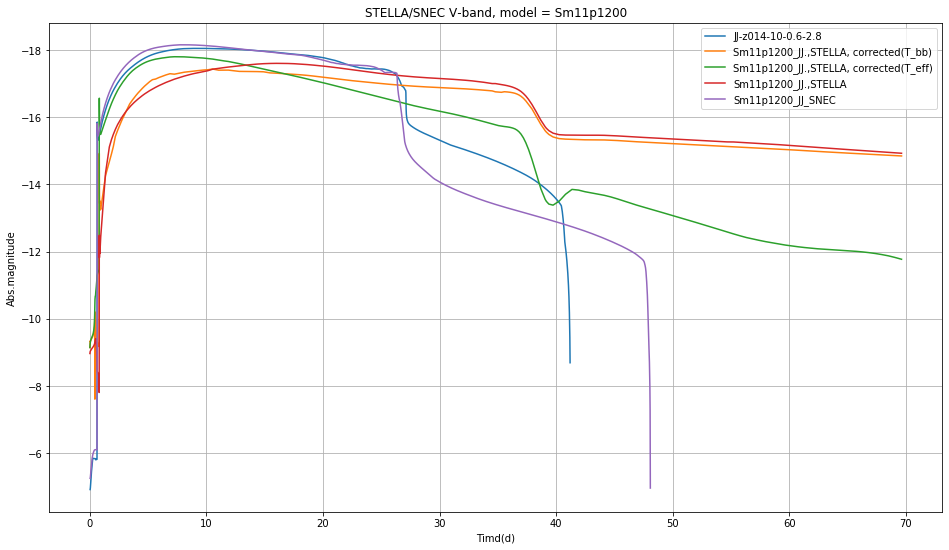

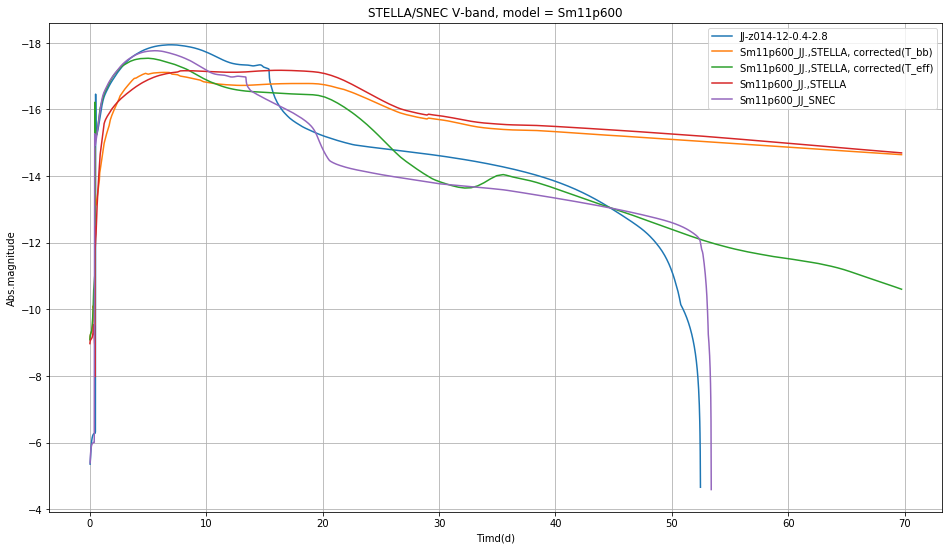

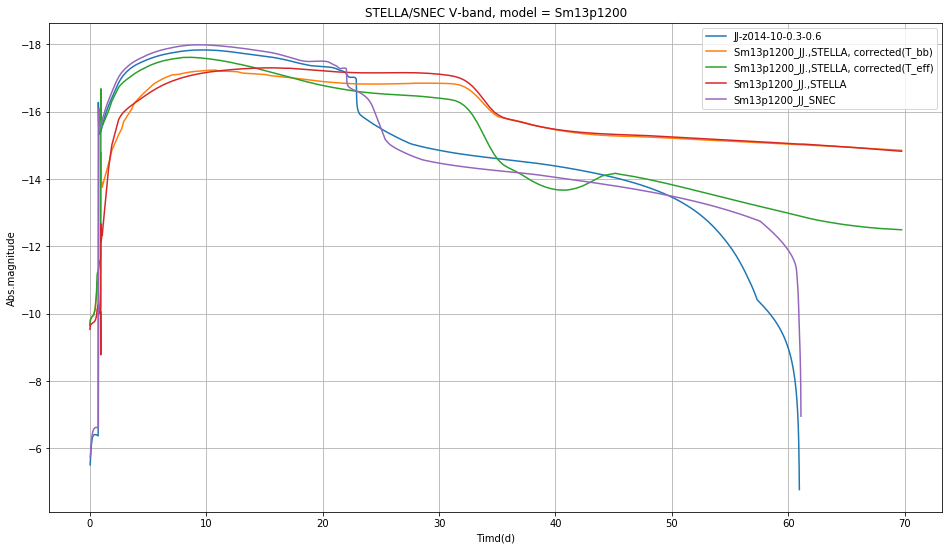

In [25]:

itr = 0
for i in listdir(TOPPATH):
    itr+=1                                                       # indicator for plots
    filedir = TOPPATH+i+'/'
    plt.rcParams["figure.figsize"] = (16,9)
    plt.figure(itr)
    for file in listdir(TOPPATH+i):
        if file[-14:-4] == 'magnitudes':
            LC = np.genfromtxt(filedir+ file)
            time = LC[:,0] ; V = LC[:,10] ; label = 'SNEC'
            mask = np.zeros(time.shape, bool)                    #masking SNEC file
            mask[(time/86400>0)&(time/86400<70)] = True
            plt.plot(time[mask]/86400, V[mask], label = file[:-14])#+','+label)
        else:
            LC = np.genfromtxt(filedir + file, skip_header=86)
            time = LC[:,0] ; V = LC[:,9] ; MBol = LC[:,6] ; label = 'STELLA'
            mask = np.zeros(time.shape, bool)                     #masking STELLA file
            mask[(time > 0)&(time<70)] = True

            ###### WARNING ###### in some of the early procedure, T_bb will exceed the interpolated region! 
            T_bb = LC[:,1];T_eff = LC[:,3]
            Tbb_mask = np.ones(time.shape, bool)                 #masking Temperature in the intp.range
            Tbb_mask[(T_bb<1000)|(T_bb>1e6)] = False
            T_bb[~Tbb_mask] = 1e6                                #remporaily set masked values as the maximum value
            BolCorrMat_bb = Bolintp(T_bb)                        #obtaining interpolated MBol correction function (Tbb)
            BolCorrMat_eff = Bolintp(T_eff)


            MBol_Corr_bb = MBol - BolCorrMat_bb[:,2]             #Corrected values
            MBol_Corr_eff = MBol-BolCorrMat_eff[:,2]
            Total_mask = Tbb_mask & mask
            plt.plot(time[Total_mask], MBol_Corr_bb[Total_mask], label = file[:-6]+','+label+', corrected(T_bb)')
            plt.plot(time[mask], MBol_Corr_eff[mask], label = file[:-6]+','+label+', corrected(T_eff)')
            plt.plot(time[mask], V[mask], label = file[:-6]+','+label)
        
        
            #print(np.vstack([MBol]*5).T,'\n', BolCorrMat[100:120])
            #print(T_bb[1220:1240])                              # TODO : Label each band automatically
    plt.gca().invert_yaxis()
    plt.title("STELLA/SNEC V-band, model = %s"%i)
    plt.xlabel("Timd(d)");plt.ylabel("Abs.magnitude")
    plt.grid()
    plt.legend()
plt.show()